In [2]:
#in this script we are taking our QC-ed 2d ishiguro cell data and using celltypist to annotate it
import scanpy as sc
import anndata as ad
import pandas as pd

In [3]:
import celltypist
from celltypist import models

In [4]:
adata = sc.read_csv(filename="/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/ishiguro/2d/processed/countdata.tsv", delimiter='\t', first_column_names=True )


In [5]:
print(adata)

AnnData object with n_obs × n_vars = 3470 × 28332


In [6]:
adata.layers["counts"] = adata.X.copy() #store the raw count data

In [7]:
#normalising gene expression counts before celltypist run
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum = 10000)
# Logarithmize the data
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=2000)

sc.tl.pca(adata)

sc.pp.neighbors(adata)

sc.tl.umap(adata)

# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
#note that in G2G lab notebook they run CellTypist using highly variable genes, but CellTypist documentation recommends all genes
#we will run with all genes

/g/data/yr31/hb1618/iPSC_project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
models.models_path

'/home/561/hb1618/.celltypist/data/models'

In [9]:
predictions = celltypist.annotate(adata, model = "Pan_Fetal_Human.pkl", majority_voting = True)

🔬 Input data has 3470 cells and 28332 genes
🔗 Matching reference genes in the model
🧬 4952 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [10]:
adata.obs['celltypist_panfetal_predictions'] = predictions.predicted_labels['majority_voting']
print(adata)
predictions

AnnData object with n_obs × n_vars = 3470 × 28332
    obs: 'leiden', 'celltypist_panfetal_predictions'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'over_clustering'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


CellTypist prediction result for 3470 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 3470 query cells and 138 cell types
    probability_matrix: data frame with 3470 query cells and 138 cell types
    adata: AnnData object referred

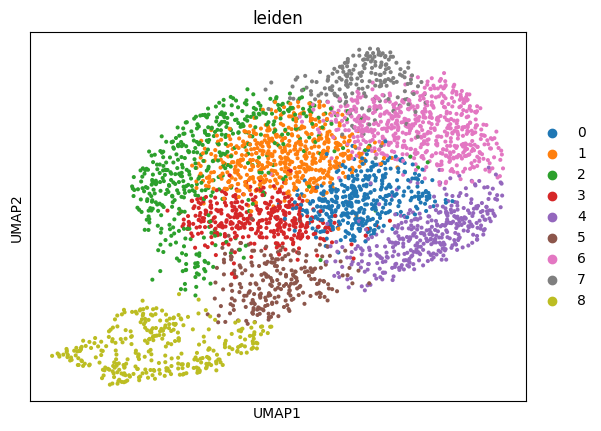

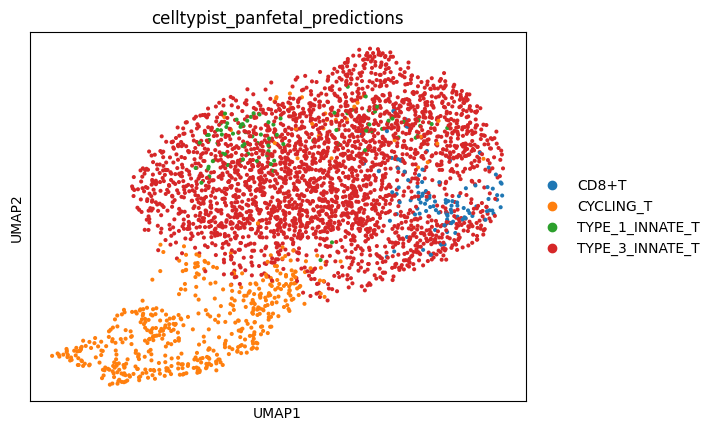

In [11]:
sc.pl.umap(adata,color=['leiden']) #leiden refers to the clusters we generated prior
sc.pl.umap(adata,color='celltypist_panfetal_predictions') #these are our predicted cell types

In [12]:
#experimenting with other models
predictions_high = celltypist.annotate(adata, model = "Immune_All_High.pkl", majority_voting = True)
predictions_low = celltypist.annotate(adata, model = "Immune_All_Low.pkl", majority_voting = True)
predictions_thymus = celltypist.annotate(adata, model = "Developing_Human_Thymus.pkl", majority_voting = True)

🔬 Input data has 3470 cells and 28332 genes
🔗 Matching reference genes in the model
🧬 4605 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3470 cells and 28332 genes
🔗 Matching reference genes in the model
🧬 4605 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3470 cells and 28332 genes
🔗 Matching reference genes in the model
🧬 3489 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph 

In [13]:
adata.obs['celltypist_high_predictions'] = predictions_high.predicted_labels['majority_voting']
adata.obs['celltypist_low_predictions'] = predictions_low.predicted_labels['majority_voting']
adata.obs['celltypist_thymus_predictions'] = predictions_thymus.predicted_labels['majority_voting']

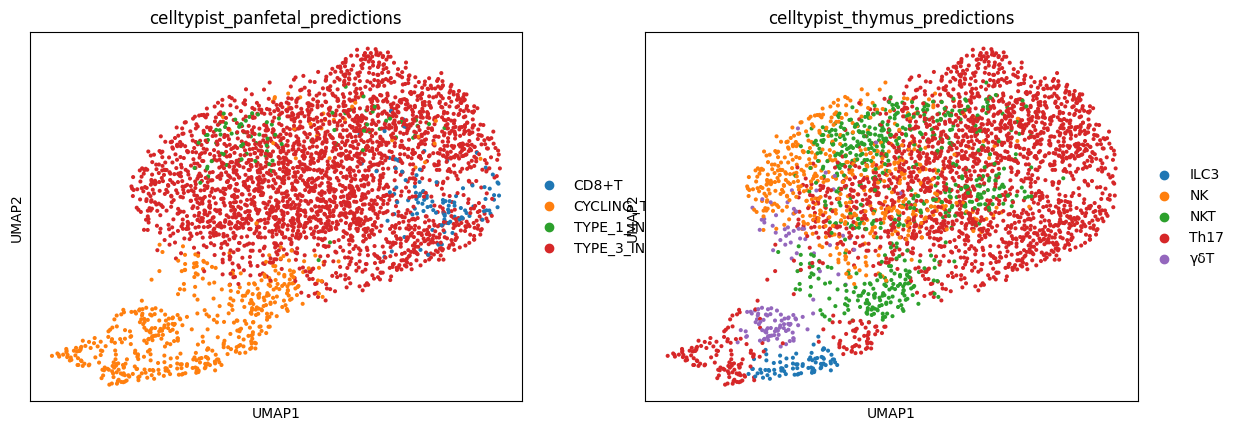

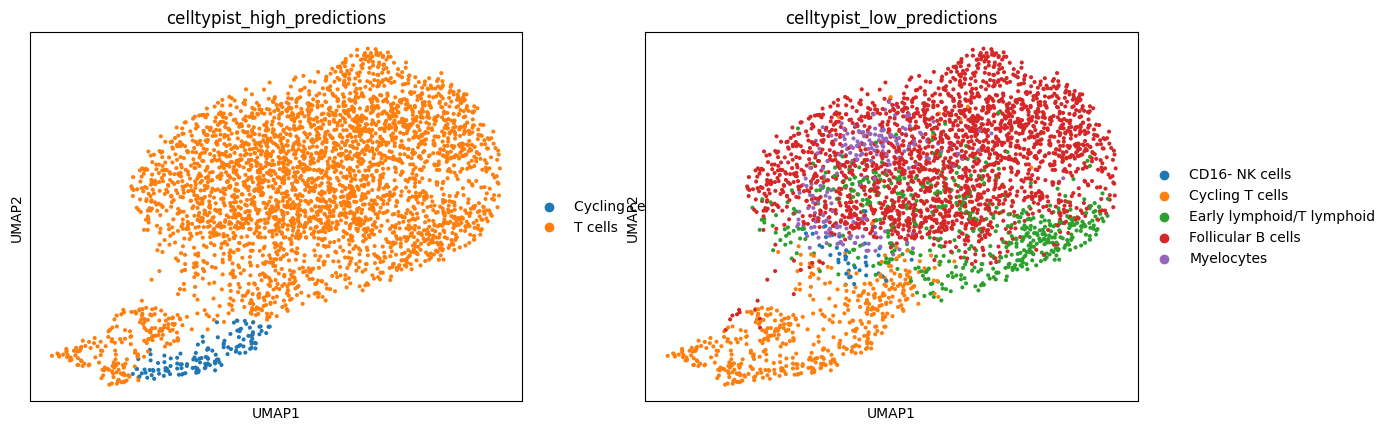

In [14]:
sc.pl.umap(adata,color=['celltypist_panfetal_predictions', 'celltypist_thymus_predictions'])
sc.pl.umap(adata,color=['celltypist_high_predictions','celltypist_low_predictions']) #low granularity

In [15]:
#exporting metadata
# Save the metadata, containing our new celltypist predictions, to the existing metadata file
adata.obs.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/ishiguro/2d/processed/metadata.csv")